In [1]:
from src.reachability_analysis.simulation import load_config, get_test_label, get_test_clsuter, run_scenario, get_data, get_initial_conditions
from src.reachability_analysis.labeling_oracle import LABELS, LabelingOracleSINDData
from src.reachability_analysis.utils import load_data
import matplotlib.pyplot as plt
from PIL import Image
import os


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization m

In [2]:
ROOT = os.getcwd()
ROOT_RESOURCES = os.getcwd() + '/resources'

In [3]:
REVERSED_LABELS = {value: key for key, value in LABELS.items()}

### Zonotope Colors

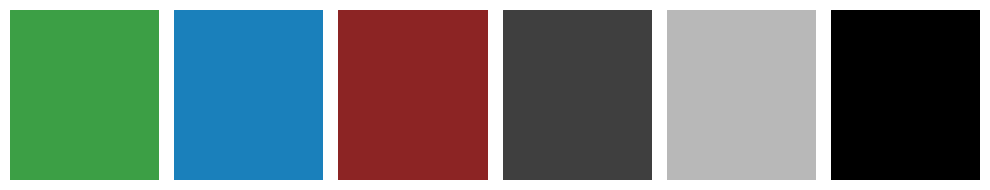

In [4]:
import matplotlib.pyplot as plt
import numpy as np

colors = [
    [60/255 , 159/255 , 69/255 ], # Behavioral Tajectory
    [26/255 , 128/255 , 187/255 ], # Clusters
    [0.55, 0.14, 0.14], # Baseline Zonotope
    # [0/255 , 0/255 , 0/255 ], # Current Trajectory
    [63/255, 63/255, 63/255], # Current Trajectory
    [184/255 , 184/255 , 184/255 ], # Future Trajectory
    [0/255 , 0/255 , 0/255 ], # Current Position
    # [52/255 , 78/255 , 92/255 ], # Position
]

# Create a figure and a set of subplots
fig, ax = plt.subplots(1, len(colors), figsize=(10, 2))

# Display each color
for i, color in enumerate(colors):
    ax[i].add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
    ax[i].set_axis_off()
    # ax[i].set_title(f'RGB {color}', fontsize=10)

plt.tight_layout()
plt.show()

### Zonotopes

In [5]:
ROOT_RESOURCES = ROOT + '/resources'
config = load_config()

Labeling data: 100%|██████████| 3/3 [00:00<00:00, 4562.33it/s]
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-04-28 00:56:55,126 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=Tru

Loaded model from /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/checkpoints/model_best.pth. Epoch: 28
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.160607
{'l_3': 'Label: cross_illegal', 'c_12': 'Cluster: 12'}


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


3 39
7 7
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


Calculating reachable sets: 100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


12 145
58 58
{-1: 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57}


Calculating reachable sets: 100%|██████████| 48/48 [00:08<00:00,  5.38it/s]


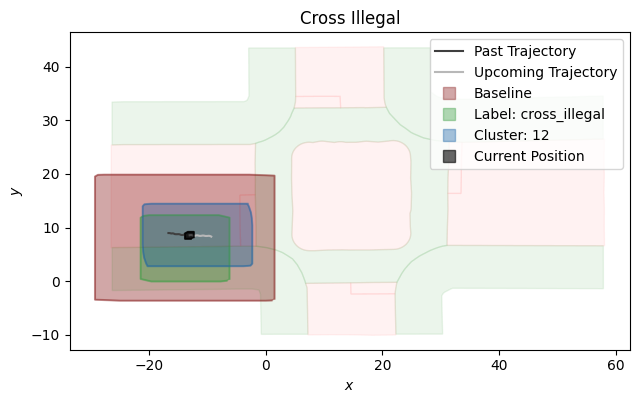

_z_ {'Label: cross_illegal': [zonotope], 'Cluster: 12': [zonotope]}


In [6]:
config_test = config.copy()
config_test['data_dir'] = ROOT_RESOURCES + '/test/cross_illegal_8_11_1'
test_labeling_oracle = LabelingOracleSINDData(config_test)

trajectory, l = get_test_label(test_labeling_oracle)
c = get_test_clsuter(config_test, test_labeling_oracle)
test_cases = {f'l_{l}': f'Label: {REVERSED_LABELS[l]}', f'c_{c}': f'Cluster: {c}'}

print(test_cases)
run_scenario(trajectory=trajectory, config=config, labels=test_cases, show_plot=True, save_plot=config_test['data_dir'])

Labeling data: 100%|██████████| 3/3 [00:00<00:00, 2909.34it/s]
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-04-28 00:59:51,091 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=Tru

Loaded model from /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/checkpoints/model_best.pth. Epoch: 28
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.0872709
{'l_4': 'Label: crossing_now', 'c_17': 'Cluster: 17'}


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


4 39
7 7
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


Calculating reachable sets: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


17 5
58 58
{-1: 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57}


Calculating reachable sets: 100%|██████████| 48/48 [00:00<00:00, 147.22it/s]


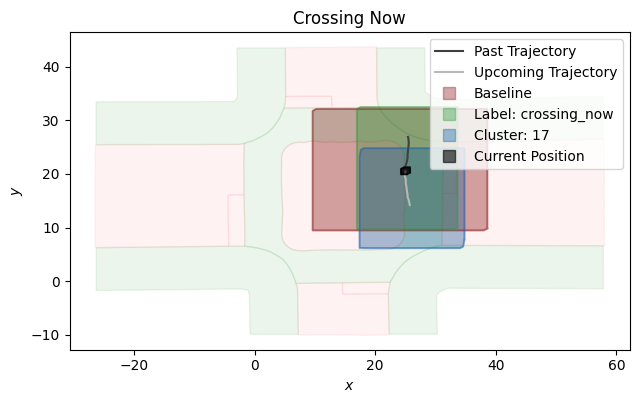

_z_ {'Label: crossing_now': [zonotope], 'Cluster: 17': [zonotope]}


In [8]:
config_test = config.copy()
config_test['data_dir'] = ROOT_RESOURCES + '/test/crossing_now_7_28_1'
test_labeling_oracle = LabelingOracleSINDData(config_test)

trajectory, l = get_test_label(test_labeling_oracle)
c = get_test_clsuter(config_test, test_labeling_oracle)
test_cases = {f'l_{l}': f'Label: {REVERSED_LABELS[l]}', f'c_{c}': f'Cluster: {c}'}

print(test_cases)
run_scenario(trajectory=trajectory, config=config, labels=test_cases, show_plot=True)

Labeling data: 100%|██████████| 4/4 [00:00<00:00, 350.19it/s]
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-04-28 01:00:16,445 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True

0
Loaded model from /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/checkpoints/model_best.pth. Epoch: 28
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.130675
{'l_0': 'Label: cross_left', 'c_20': 'Cluster: 20'}


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


0 39
7 7
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


Calculating reachable sets: 100%|██████████| 48/48 [00:14<00:00,  3.23it/s]


20 25
58 58
{-1: 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57}


Calculating reachable sets: 100%|██████████| 48/48 [00:01<00:00, 37.96it/s]


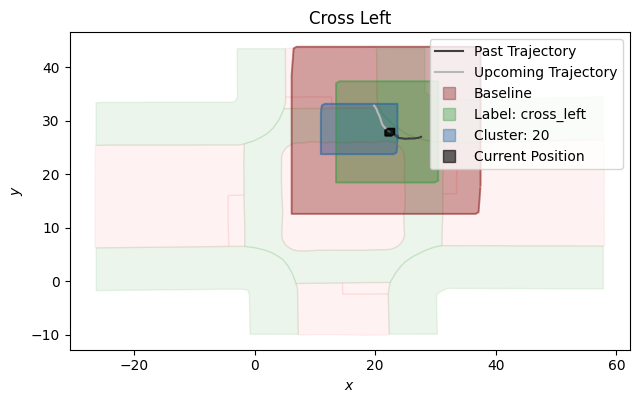

_z_ {'Label: cross_left': [zonotope], 'Cluster: 20': [zonotope]}


In [9]:
config_test = config.copy()
config_test['data_dir'] = ROOT_RESOURCES + '/test/cross_left_8_6_4'
test_labeling_oracle = LabelingOracleSINDData(config_test)

trajectory, l = get_test_label(test_labeling_oracle)
print(l)
c = get_test_clsuter(config_test, test_labeling_oracle)
test_cases = {f'l_{l}': f'Label: {REVERSED_LABELS[l]}', f'c_{c}': f'Cluster: {c}'}

print(test_cases)
run_scenario(trajectory=trajectory, config=config, labels=test_cases, show_plot=True)

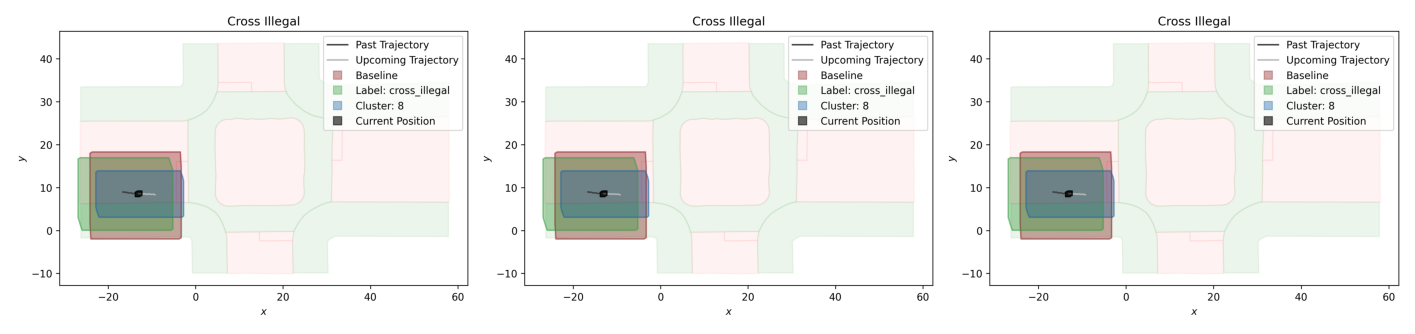

In [10]:
def combine_images(image_paths, output_path):
    # Determine the number of images
    num_images = len(image_paths)
    
    # Create a matplotlib figure with multiple subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images * 6, 5))
    
    # Check if there's only one subplot (axes could be an AxesSubplot object, not an array)
    if num_images == 1:
        axes = [axes]
    
    # Loop through the images and their respective axes
    for ax, img_path in zip(axes, image_paths):
        # Open the image file
        with Image.open(img_path) as img:
            # Convert the image file to an array
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust spacing between images if needed
    plt.savefig(output_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

# Example usage
image_paths = [
    ROOT_RESOURCES + '/test/cross_illegal_8_11_1/0.png',
    ROOT_RESOURCES + '/test/cross_illegal_8_11_1/0.png',
    ROOT_RESOURCES + '/test/cross_illegal_8_11_1/0.png',
]
output_path = ROOT_RESOURCES + '/test/combined_image.jpg'

combine_images(image_paths, output_path)

### Clsuter picked for Zonotope

In [11]:
c , l

(20, 0)

In [16]:
_sind_, d, _, mapping = get_data(_load=True, config=config, test_case=(c, 'Cluster'))
_mode = mapping[c]
_mode

20 25
58 58
{-1: 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57}


20

In [17]:
len(d[_mode])

25

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


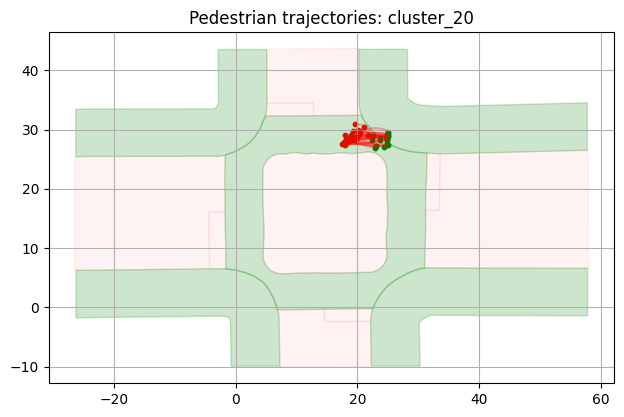

In [18]:
_sind_.map.plot_dataset(pedestrian_data={i: data for i, data in enumerate(d[_mode])}, color='red', title=f'cluster_{c}', alpha_trajectories=0.3)

### Other data

In [19]:
from example_code.data.data_reader import SinD
from src.reachability_analysis.input_state import structure_input_data, separate_data_to_class
from src.reachability_analysis.simulation import reachability_for_specific_position_and_mode
import numpy as np

In [20]:
ROOT_RESOURCES = ROOT + '/resources'
config = load_config()

In [21]:
input_len = 90
num_features =6

In [22]:
sind = SinD()
# train_data = sind.data(input_len=input_len, save_data=False)
# train_labels = sind.labels(train_data, input_len=90, save_data=False)
train_data = load_data('sind_original.pkl')
train_labels = load_data('sind_labels_original.pkl')
train_data.shape, train_labels.shape

((261086, 540), (261086,))

In [23]:
train_data_new = train_data.reshape(train_data.shape[0], num_features, input_len).transpose(0, 2, 1)

In [24]:
def structure_input_data(data: np.ndarray, labels: np.ndarray):
    """Drops random trajectories such that the data for each class
    is of the same length

    Parameters:
    -----------
    data : np.ndarray
        The chunks from the dataset
    labels: np.ndarray
        The true labels for the data
    """
    _d = {}.fromkeys(labels)
    [_d.update({i: []}) for i in _d.keys()]
    [_d[_l].append(data[i]) for i, _l in enumerate(labels)]
    _lens = [len(v) for v in _d.values()]
    _min_len = min(_lens)
    new_d = []
    new_l = []
    print(_min_len)
    for _l, _v in _d.items():
        _v = np.array(_v)
        _ids = np.random.randint(0, len(_v), size=30)
        new_d = [*new_d, *_v[_ids]]
        new_l = [*new_l, *[_l] * 30]
    return np.array(new_d), np.array(new_l)

In [25]:
train_data_, train_labels_ = structure_input_data(train_data_new, train_labels)
d_ = separate_data_to_class(train_data_, train_labels_, size=len(set(train_labels_)))
train_data_[0].shape, train_labels_.shape, d_[0].shape

676


((90, 6), (210,), (30, 90, 6))

In [ ]:
config_test = config.copy()
config_test['data_dir'] = ROOT_RESOURCES + '/test/cross_illegal_8_11_1'

trajectory, l, test_labeling_oracle = get_test_label(config_test)
c = get_test_clsuter(config_test, test_labeling_oracle)

In [ ]:
position, velocity = get_initial_conditions(trajectory)

In [ ]:
position, velocity, input_len, len(d_), d_[0].shape, l

(array([-13.04118909,   8.54022801]),
 array([ 0.77133718, -0.07469204]),
 90,
 7,
 (30, 90, 6),
 3)

In [ ]:
test_cases = {f'l_{l}': f'Label: {REVERSED_LABELS[l]}', f'c_{c}': f'Cluster: {c}'}

In [ ]:
zonotope = reachability_for_specific_position_and_mode(pos=position, vel=velocity, c=l, d=d_, sind=sind, sim=True)